In [ ]:
# execute this cell before you start
import time

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)


2024-03-18 13:48:55.223206: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 13:48:55.238872: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 13:48:55.276744: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 13:48:55.276776: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 13:48:55.277662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

2.15.0


# Q1 The CIFAR-10 dataset.

(10 marks)

Consider the data in  [`keras.datasets.cifar10`](https://www.tensorflow.org/datasets/catalog/cifar10) and train a network which reliably categorizes the data.
Try to understand tradeoffs:

- What increases computing time?
- What increases accuracy?

This dataset has its own [Wikipedia page](https://en.wikipedia.org/wiki/CIFAR-10), and is often used as benchmark for new proposed methods.
You can take the cat/dog example from the lecture as a starting point, but you can also find plenty of inspiration in the Internet.  As before, it is not forbidden to get such inspiration, but please stay in the framework of what is covered in the lecture and clearly cite from where you take what.


To get you started, here some code to show with which you can browse the data:

In [ ]:
(train_data,train_labels),(test_data,test_labels) = keras.datasets.cifar10.load_data()

train_N = 5000
x_val = train_data[:train_N]
partial_x_train = train_data[train_N:]

y_val = train_labels[:train_N]
partial_y_train = train_labels[train_N:]

In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1), # rotates by up to 36 degrees.
        layers.experimental.preprocessing.RandomZoom(0.1),
        layers.experimental.preprocessing.RandomFlip("vertical"),
    ]
)

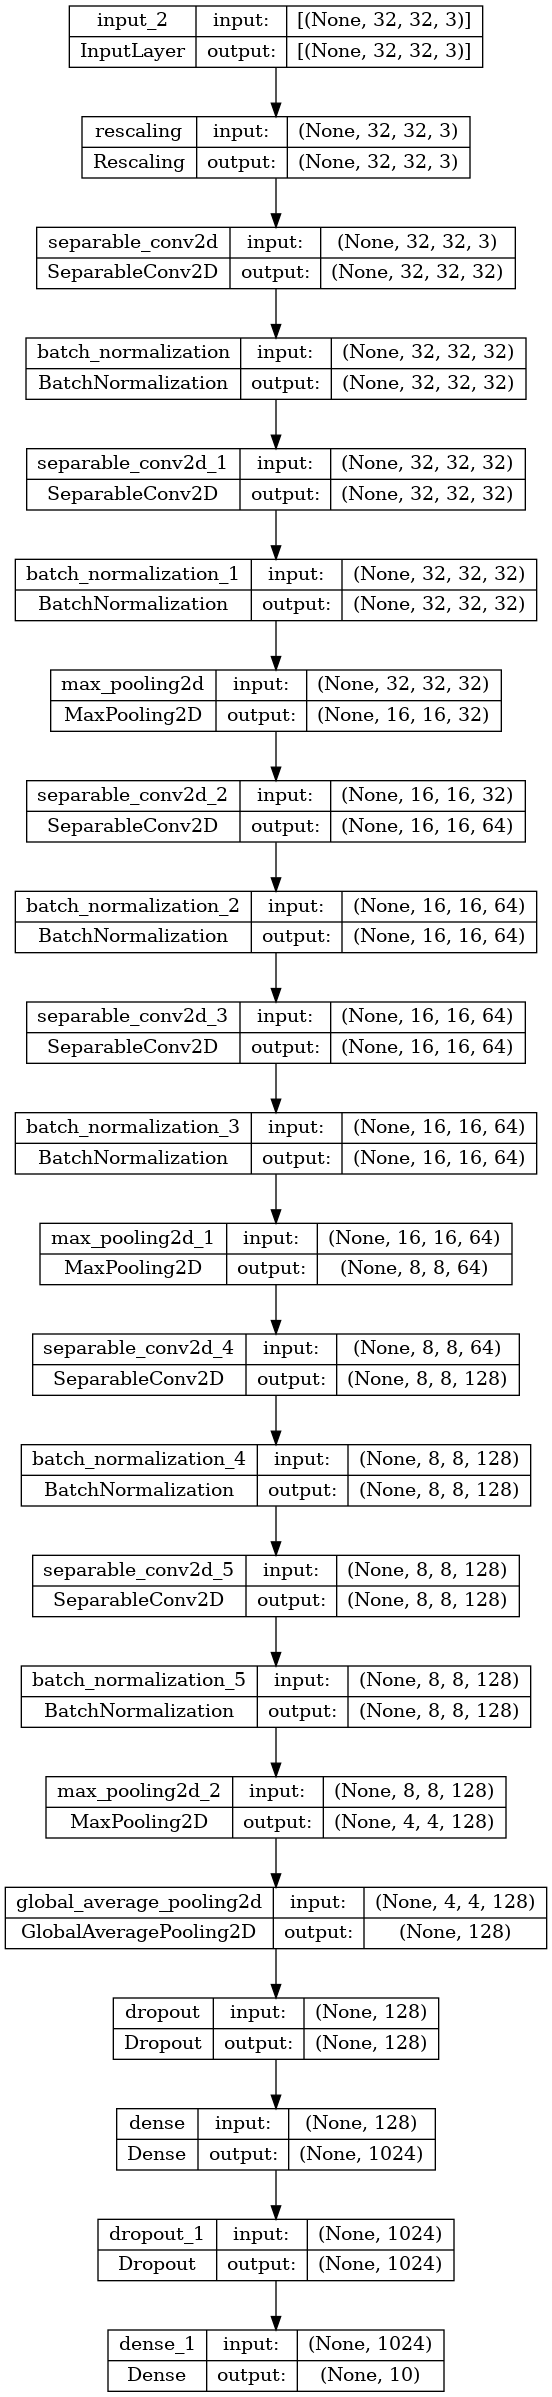

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, SeparableConv2D
from tensorflow.keras.layers import GlobalMaxPooling2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model
# number of classes
K = 10

i = data_augmentation(Input(shape=(32, 32, 3)))
x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(i)

for size in [32, 64, 128]:
    x = SeparableConv2D(size, 3, 1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = SeparableConv2D(size, 3, 1, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

x = layers.GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)

# Hidden layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)

# last hidden layer i.e.. output layer
x = Dense(K, activation='softmax')(x)

model = Model(i, x)
keras.utils.plot_model(model, show_shapes=True)

# model description

Epoch 1/10
704/704 [==============================] - 35s 46ms/step - loss: 1.4127 - accuracy: 0.4828 - val_loss: 1.2320 - val_accuracy: 0.5680
Epoch 2/10
704/704 [==============================] - 29s 42ms/step - loss: 1.0670 - accuracy: 0.6193 - val_loss: 1.1070 - val_accuracy: 0.6112
Epoch 3/10
704/704 [==============================] - 29s 42ms/step - loss: 0.9314 - accuracy: 0.6720 - val_loss: 0.9165 - val_accuracy: 0.6768
Epoch 4/10
704/704 [==============================] - 29s 41ms/step - loss: 0.8394 - accuracy: 0.7060 - val_loss: 0.8955 - val_accuracy: 0.6888
Epoch 5/10
704/704 [==============================] - 28s 40ms/step - loss: 0.7691 - accuracy: 0.7288 - val_loss: 0.7990 - val_accuracy: 0.7192
Epoch 6/10
704/704 [==============================] - 28s 40ms/step - loss: 0.7147 - accuracy: 0.7486 - val_loss: 0.7994 - val_accuracy: 0.7256
Epoch 7/10
704/704 [==============================] - 28s 39ms/step - loss: 0.6724 - accuracy: 0.7646 - val_loss: 0.7406 - val_accuracy:

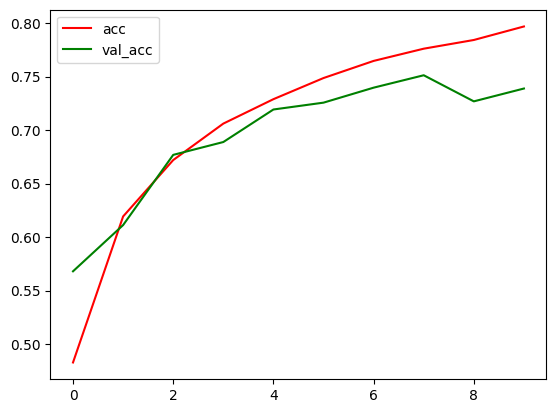

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)

start = time.time()
history = model.fit(
    partial_x_train, partial_y_train, epochs=10, batch_size=64, validation_data=(x_val, y_val), verbose=1
)

test_loss, test_acc = model.evaluate(test_data, test_labels)
end = time.time()
print("Time:", (end-start))
print("Test accuracy:", test_acc)

plt.plot(history.history['accuracy'], label='acc', color='red')
plt.plot(history.history['val_accuracy'], label='val_acc', color='green')
plt.legend()

Filters look for patterns within the images (edges, contrast, etc). There is an optimun number of filters to use within each convolution layer and across multiple convolution layers. Using just one convolution layer with a greater number of filters is not as effect. This is because a single convolution layer cannot detect hieracheal patterns within the img alone. The filter uses a 3x3 matrix to create a feature map of the image as the output. The stride, determines the pixel number between each iteration. Padding ensures that feature map is the same dimesions as the image.

Separate vs standard:
Separate is faster as it does fewer multipications than standard convolution. It does this by separating the convolution into depth-wise and point-wise convolution. The depthwise convolution transforms the image without accounting for depth using just a 3x3x1 matrix. Pointwise convolution then expands this by using a 1x1x3 matrix to account for the depth. This reduces the overall number of multipications, thus reducing computational complexity.

Batch Normalising - takes the output of the convolution layer (collection of feature maps) and normalises each of the feature maps. This is done to increase training speed and reduce vanishing gradients.

Activation layer (ReLu) is used to introduce non-linearity into the model to detect complex patterns.

Max pooling - Max pooling layers are used to reduce the height and width of the layer (i.e. reducing the size of two of the dimensions) so that calculations become easier (saving computational time) while retaining the most important information. It does this by summarising regions of the feature maps, selecting the max value of these regions. In other words the purpose of using a max pooling layer to decrease computational time without losing too much accuracy.

Global pooling and flatten - These are used to convert the previous layer into a single dimension. Global pooling summarises the height and width of the entire feature map into vectors of the channel dimension. Flatten condenses the entire information of the previous layer into a single dimension. Global pooling is more effective when overfitting occurs as it only takes a summary of the height and width when converting to a single dimension. Flatten is more effective when you want to retain more information to help explain the model better.

Data augmentation - This does not improve the accuracy, or computational time of the model. This also doesn't help with overfitting as the global pooling layer has already helped with this. It is still used in this model however, as it helps to improve the robustness of the model incase there are any images that do not follow the same structure as those from the training set.

The optimal model found for this dataset returned on average an accuracy of ~76% and a time of ~190 seconds. It is possible to further increase the accuracy of the model by increasing the kernal sizes and epochs, however, this would increase the computational time signifcantly (1000s) while only increasing the accuracy by ~8%. Therefore, the final model reduces the accuracy of the model while retaining relatively short computational time. The model design was created as such based on the reasoning from the above information.

# Q2 Deep Learning in Earth Science


Consider the notebook [Bamboo_forest_detection.ipynb](https://colab.research.google.com/github/totti0223/deep_learning_for_biologists_with_keras/blob/master/notebooks/bamboo_forest_detection.ipynb) on using machine learning for detecting vegetation from satellite images

a) Adapt the code such that it runs in the `tfenv` environment. If necessary, install missing packages. Explain your modification in detail. (4 marks)

b) Thoroughly explain the code in this notebook by adding markdown cells starting with "# CA" (6 marks)

# Sliding Window Combined with CNN for Bamboo forest detection

# Preface

Original Article
**Using deep learning for bamboo forest detection from Google Earth images.**

*Shuntaro Watanabe, Kazuaki Sumi, Takeshi Ise*

doi: https://doi.org/10.1101/351643

**Note**

Without using specialized  networks like U-net, but with a general CNN for classification, we still can perform a segmentation. The concept originates from the "Patch-based Classification", proposed in the following paper. See the slide below. Combining a sliding window patches with repatative CNN classification allows detection of the tumor region.

Watanabe et al., performed a similar approach to segment bamboo forests from satelite images retreived from google earth.
They express their method as "chopped images", however paying respect to the previous research, I describe this method as "Patch-based Classification" as I interpret the principle is identical.


*Deep Learning for Identifying Metastatic Breast Cancer*

*Dayong Wang Aditya Khosla⋆ Rishab Gargeya Humayun Irshad Andrew H Beck Beth Israel Deaconess Medical Center, Harvard Medical School**
https://arxiv.org/abs/1606.05718
![image](https://raw.githubusercontent.com/totti0223/deep_learning_for_biologists_with_keras/master/assets/cancer.png)




# Import Libraries

In [ ]:
import slidingwindow as sw
import numpy as np
import os
import keras.backend as K
import keras
from keras.models import Sequential
from keras import layers
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
from sklearn.utils.class_weight import compute_class_weight


2024-03-18 14:05:46.332672: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 14:05:47.050243: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-18 14:05:49.969784: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 14:05:49.980851: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 14:05:51.589119: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

# Download dataset

In [ ]:
## Download and extract dataset
!wget https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip bamboo.zip
!unzip -P bamboo bamboo.zip

--2024-03-18 13:56:07--  https://raw.githubusercontent.com/totti0223/k4b_datasets/master/bamboo.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8003::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28240432 (27M) [application/zip]
Saving to: ‘bamboo.zip.2’

bamboo.zip.2        100%[===================>]  26.93M  3.63MB/s    in 8.3s    

2024-03-18 13:56:17 (3.23 MB/s) - ‘bamboo.zip.2’ saved [28240432/28240432]

--2024-03-18 13:56:17--  http://bamboo.zip/
Resolving bamboo.zip (bamboo.zip)... failed: Name or service not known.
wget: unable to resolve host address ‘bamboo.zip’
FINISHED --2024-03-18 13:56:17--
Total wall clock time: 9.7s
Downloaded: 1 files, 27M in 8.3s (3.23 MB/s)
Archive:  bamboo.zip
caution: filename not matched:  n


## Preview

In [ ]:
!ls bamboo/train
#image names starting with "b" is image with only bamboo forest.
#image names starting with "o" is image without bamboo forest.

b10.png  b13.png  b2.png  b5.png  b8.png   o1.png  o4.png  o7.png
b11.png  b14.png  b3.png  b6.png  b9.png   o2.png  o5.png  o8.png
b12.png  b1.png   b4.png  b7.png  o10.png  o3.png  o6.png  o9.png


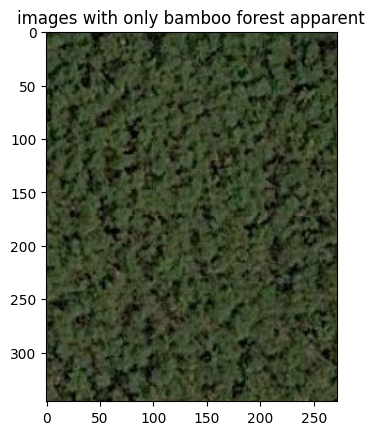

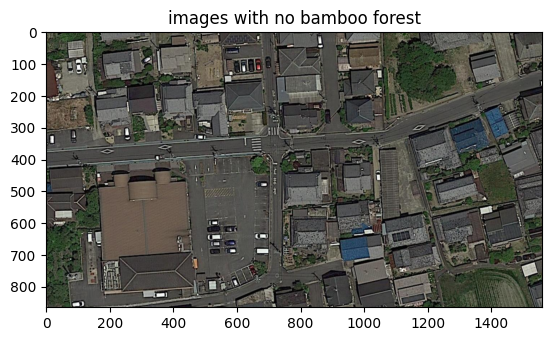

In [ ]:
plt.title("images with only bamboo forest apparent")
plt.imshow(imread("bamboo/train/b5.png"))
plt.show()

plt.title("images with no bamboo forest")
plt.imshow(imread("bamboo/train/o10.png"))
plt.show()


# Create "patches" from each image using a sliding window

# CA

Modified the below cell to allow image depth to be greater than 3. If this isn't done then image o2-o9 will not be used.

The below cell, takes each image in the train folder of the bamboo dataset and divides each image into many smaller images to expand the size of the training dataset that will be used for the CNN model in the future.

It does this by:
Iterating through each object in the specified directory and extracting every object that ends with .png. It then iterates though all the .png files and applies the function save_to_folder to them.

The save_to_folder works by:
Iterating over each image in the train folder using a sliding window of 56x56 pixels. This sliding window moves 40% of its size in both the height and width of the image. At each iteration a new image is created using the basename of the train image, plus the image number. This image is then added to the new specified directory is the image dimensions are the specified size (default = 56, 56, img.shape[2])

In [ ]:
def save_to_folder(img_path,directory,size=56,overlap=0.4):
    #read imag from path save windows to the specified directory
    img = imread(img_path)
    basename = os.path.basename(img_path)
    fname = os.path.splitext(basename)[0]
    windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, size, overlap)
    for i, window in enumerate(windows):
        ii = str("{0:05d}".format(i))
        _fname = fname + "_" + ii + ".png"
        _img = img[window.indices()]
        if _img.shape !=(size,size,img.shape[2]):
            continue
        img_target_path = os.path.join(directory,_fname)

        imsave(img_target_path,_img)

files = os.listdir("bamboo/train/")
files = [x for x in files if x.endswith(".png")]

files.sort()
for file in files:
    save_directory = "bamboo/chopped"
    file = os.path.join("bamboo/train/",file)
    save_to_folder(file,save_directory)

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o2_00045.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o2_00120.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o2_00145.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o2_00170.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o2_00250.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o2_00499.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o2_00523.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o3_00172.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o3_00405.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o3_00544.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o3_01012.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00007.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00008.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00009.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00096.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00100.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00101.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00102.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00103.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00106.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00107.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00373.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00374.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00375.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00378.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00383.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00384.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00385.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00564.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00565.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00566.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00567.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00568.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00569.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00570.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00650.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00651.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00652.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00653.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00654.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00655.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00656.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00726.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00727.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00728.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00729.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00730.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00731.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00732.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00812.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00813.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00814.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00815.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00816.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00817.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00818.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00886.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00887.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00888.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00889.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00900.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00901.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o4_00902.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o6_00295.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o6_00296.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o6_00368.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o6_00369.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o6_00370.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o6_00373.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chopped/o6_00374.png is a low contrast image
  imsave(img_target_path,_img)
/tmp/ipykernel_5998/3530308522.py:15: UserWarning: bamboo/chop

# CA

The below cell creates two lists, the training data (i.e. each image that was produced from above) and the labels data (i.e. labels relating to whether or not the images contain bamboo or not).

This is done by iterating through each filename and labelling each file a 1 (cotains bamboo) or 0 (does not contain bamboo). Each image is then normailised so that each pixel value is between 0 and 1, by dividing by 255. The images are then converted to an array and added to a new list. Similarly the corresponding labels are converted to an array and added to a new list.

In [ ]:
files = os.listdir("bamboo/chopped/")
files = [x for x in files if x.endswith(".png")]

x = []
y = []

for file in files:
    if file.startswith("b"):
        label = 1
    else:
        label = 0

    img_path = os.path.join("bamboo/chopped",file)
    img = load_img(img_path)
    img = img_to_array(img)/255
    x.append(img)
    y.append(label)

x = np.array(x)
y = np.array(y)
print(x.shape,y.shape)

(13842, 56, 56, 3) (13842,)


# CA

The below cell splits the training and label sets into two different datasets. They are split into training and validation sets for both the images and the labels. 20% of the training data is split into validation data.

In [ ]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(x,y,test_size=0.2,stratify = y)

print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(11073, 56, 56, 3)
(11073,)
(2769, 56, 56, 3)
(2769,)


# CA

The code below checks if the balanced between classes (i.e. between no bamboo and bamboo) are equal and returns the weights for each class.

The code was modified so that cw is now a dictionary containing the values outputed from the compute_class_weight function. This was done as the class_weight input for model.fit needs to be a dictionary.

In [ ]:
#compute class weight
print(np.unique(train_y,return_counts=True))
print(np.unique(valid_y,return_counts=True))

cw = compute_class_weight(class_weight="balanced", classes=np.unique(train_y), y=train_y)
cw = {k:v for k, v in enumerate(cw)}
print(cw)


(array([0, 1]), array([8980, 2093]))
(array([0, 1]), array([2245,  524]))
{0: 0.6165367483296214, 1: 2.6452460582895365}


# Build and Train CNN

# CA

The below cell creates a sequential CNN model. The training data will be trained on this model so that it can be used to predict whether an image has bamboo or not. Convolutional layers are included to improve accuracy and gather information about the images. Max pooling is used to reduce dimension sizes, improving computational efficiency. Dropout layers are used to reduce overfitting. Activation layers are used to intorduce non-linearity to detect complex patterns. Flatten layer is introduced to reduce the dimensionality of the data while retaining as much information as possible. Dense layers are used to increase accuracy of information for labeling. Final dense layer is used to assign the label to the image. Loss is binary crossentropy as the outputs are either bamboo or no bamboo (0 or 1).

In [ ]:
model = Sequential([
    layers.Conv2D(16,(3,3),name="conv1",input_shape=(56,56,3),activation="relu",padding="same"),
    layers.MaxPool2D((2,2),name="pool1"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv2",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool2"),
    layers.Dropout(0.2),
    layers.Conv2D(32,(3,3),name="conv3",padding="same"),
    layers.Activation("relu"),
    layers.MaxPool2D((2,2),name="pool3"),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1),
    layers.Activation("sigmoid",name="prediction")
]
)

model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["acc"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv2D)              (None, 56, 56, 16)        448       
                                                                 
 pool1 (MaxPooling2D)        (None, 28, 28, 16)        0         
                                                                 
 dropout (Dropout)           (None, 28, 28, 16)        0         
                                                                 
 conv2 (Conv2D)              (None, 28, 28, 32)        4640      
                                                                 
 activation (Activation)     (None, 28, 28, 32)        0         
                                                                 
 pool2 (MaxPooling2D)        (None, 14, 14, 32)        0         
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 32)        0

# CA

In the cell below the model is trained using the training and validation data that was previously created. The class weights were also included to given different weights to the classes during training.

In [ ]:
history = model.fit(train_x,train_y,epochs=10,validation_data=(valid_x,valid_y),class_weight=cw)

Epoch 1/10
347/347 [==============================] - 7s 17ms/step - loss: 0.3933 - acc: 0.7531 - val_loss: 0.3383 - val_acc: 0.8108
Epoch 2/10
347/347 [==============================] - 6s 16ms/step - loss: 0.2181 - acc: 0.8455 - val_loss: 0.0687 - val_acc: 0.9747
Epoch 3/10
347/347 [==============================] - 5s 16ms/step - loss: 0.0739 - acc: 0.9715 - val_loss: 0.0327 - val_acc: 0.9892
Epoch 4/10
347/347 [==============================] - 5s 16ms/step - loss: 0.0397 - acc: 0.9828 - val_loss: 0.0126 - val_acc: 0.9953
Epoch 5/10
347/347 [==============================] - 5s 16ms/step - loss: 0.0371 - acc: 0.9851 - val_loss: 0.0094 - val_acc: 0.9975
Epoch 6/10
347/347 [==============================] - 5s 16ms/step - loss: 0.0333 - acc: 0.9884 - val_loss: 0.0104 - val_acc: 0.9971
Epoch 7/10
347/347 [==============================] - 6s 16ms/step - loss: 0.0509 - acc: 0.9820 - val_loss: 0.0116 - val_acc: 0.9967
Epoch 8/10
347/347 [==============================] - 5s 16ms/step - 

# Evaluate against Test Data

# CA

The cell below does the same image preprocessing on the test image as it did on the training images. A summary of this is: normalising the image and segmenting the image into multiple smaller images.

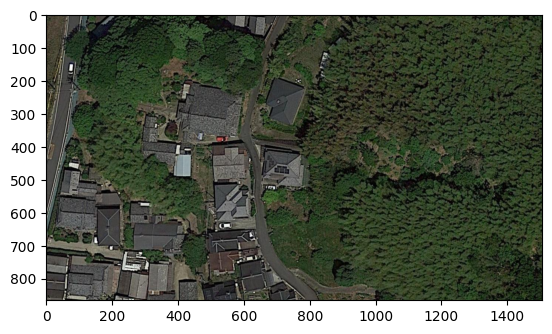

37
2405 37 65


In [ ]:
#read test data
img_path = "bamboo/test/test_image.png"
img = load_img(img_path)
img = img_to_array(img)/255
plt.imshow(img)
plt.show()

#create subimages
patches = []
windows = sw.generate(img, sw.DimOrder.HeightWidthChannel, 56, 0.6)
for i,window in enumerate(windows):
    _img = img[window.indices()]
    patches.append(_img)
patches = np.array(patches)

#check total images, how many images are tiled at height direction, and width direction
n_total = len(windows)
_x = 0
for i,window in enumerate(windows):
    if _x != window.x:
        n_x = i
        print(n_x)
        break
    _x = window.x


print(n_total,n_x,n_total//n_x)

# CA

Predicts the probability of bamboo coverage for each segmented image and reconstructs them back into a single image but with a different image shape and plots it.

76/76 [==============================] - 0s 5ms/step
(2405, 1)
[[1.9874767e-07]
 [7.8555466e-08]
 [5.8297929e-11]
 ...
 [9.6340728e-01]
 [9.8942953e-01]
 [9.9485558e-01]]


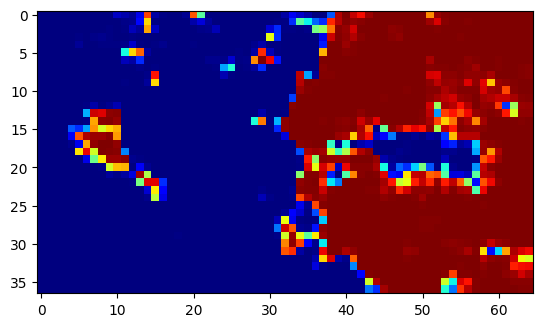

In [ ]:
#predict the bamboo probability for all the cropped images, and reshape back to its original form.
predictions = model.predict(patches)
print(predictions.shape)
print(predictions)

bamboo = np.reshape(predictions,(n_total//n_x,n_x))
bamboo = np.rot90(bamboo)
bamboo = np.flip(bamboo,axis=0)
plt.imshow(bamboo,cmap="jet")

note that each images correspond to 1 pixel of probability, and the size is not compatible with the input images.
we will caculate the ratio factor and resize it.

# CA

Determines the difference between the height and width dimensions of the orginial test image and the predicted image. The predicted image is then zoomed to approximately the same dimensions as the original test image.

In [ ]:
h_factor = img.shape[0]//bamboo.shape[0]
w_factor = img.shape[1]//bamboo.shape[1]
print(h_factor)

from scipy.ndimage import zoom
zoomed = zoom(bamboo,(h_factor,w_factor))

print(zoomed.shape)

23
(851, 1495)


# CA

The final cell plots the original test image and the newly zoomed predictions that displays the areas of the image that contain bamboo and the areas that do not contain bamboo. This is displayed using a heatmap with bambo convered areas appears ~red and areas without bamboo are ~blue.

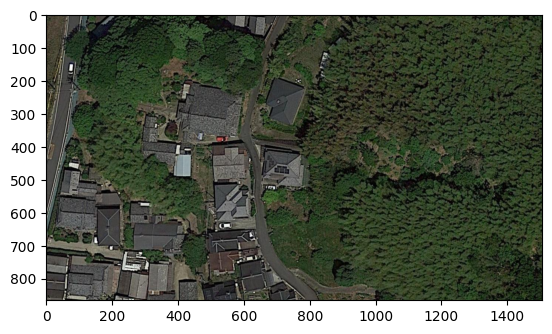

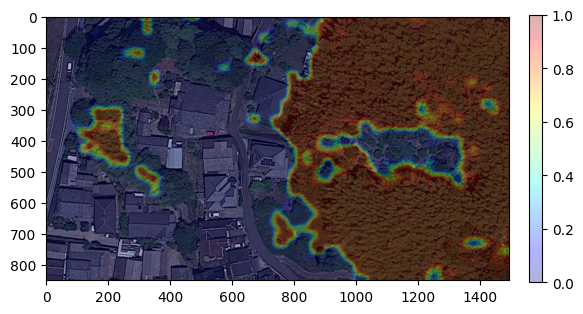

In [ ]:
#result
plt.imshow(img)
plt.show()

plt.imshow(img)
plt.imshow(zoomed,alpha=0.3,vmax=1.0,vmin=0,cmap="jet")

plt.colorbar(fraction=0.027, pad=0.04,alpha=0)
plt.show()